In [1]:
import os
import os.path
import pyarrow as pa
import pyarrow.csv as csv
import pandas as pd
import bisect
from zipfile import *
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib_venn import venn3
import numpy as np
import re
import seaborn as sns
from time import process_time as pt
from Bio.Seq import Seq
from Bio import pairwise2
from matplotlib.colors import LogNorm, Normalize
from matplotlib.colors import LinearSegmentedColormap
import sys
import statistics
from tqdm import tqdm 
import swifter
import glob
from itertools import zip_longest
from collections import Counter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cairosvg
import math

In [2]:
def find_position(name):
    name = name.split(', ')
    locations = []
    for subname in name:
        loc = int([re.findall(r'(\w+?)(\d+)', subname)[0] ][0][1])
        locations = locations +[loc]
    return locations

def expand_dataframe(row):
    cols = ['position','mutation_type','mutation_name','log2_fold_chage','amp']
    df = pd.DataFrame(columns=cols)
    for loc in row['position']:
        data1 = [[loc,row['mutation_type'],row['mutation_name'],row['Week3_PoolA_Log2FC'],row['amp']]]
        df1 = pd.DataFrame(data1,columns = cols)
        data2 = [[loc,row['mutation_type'],row['mutation_name'],row['Week3_PoolB_Log2FC'],row['amp']]]
        df2 = pd.DataFrame(data2,columns = cols)
        data3 = [[loc,row['mutation_type'],row['mutation_name'],row['Week3_PoolC_Log2FC'],row['amp']]]
        df3 = pd.DataFrame(data3,columns = cols)
        df = pd.concat([df,df1,df2,df3])
    return df

def unique(list1): #return only the unique elements of a list (no duplicates)
    x = np.array(list1)
    unique_list = np.unique(x).tolist()
    return unique_list

def check_amplicon(row,combined_df):
    pos = row['position']
    poss_amps = unique(combined_df[combined_df['position'].apply(lambda x: x== pos)]['amp'].tolist())
    return row['amp'] in poss_amps

def make_cm(colors,num):
    temp = LinearSegmentedColormap.from_list(name='temp',colors=colors,N=num)
    return temp

def make_square_cm(c_bl,c_br,c_tl,c_tr,num_div):
    colorslist = []
    temp_cm = make_cm([c_bl,c_tl],num_div)
    left = [temp_cm(x) for x in range(num_div)]
    temp_cm = make_cm([c_br,c_tr],num_div)
    right = [temp_cm(x) for x in range(num_div)]
    for i in range(num_div):
        temp_cm = make_cm([left[i],right[i]],num_div)
        colorslist = colorslist + [temp_cm(x) for x in range(num_div)]
    keys = [(x,y) for x in range(num_div) for y in range(num_div)]
    vals = [x for x in range(num_div*num_div)]
    colordict = dict(zip(keys, vals))
    return colorslist,colordict

def assign_colorvals(tdf,first,last, colordict):
    colorlist = []
    for x in range(first,last+1):
        if x in tdf.position.tolist():
            p = round(np.nanmean(tdf[tdf.position==x]['persistence'].tolist()),0)
            if np.isnan(p):
                p=0
            d = round(np.nanmean(tdf[tdf.position==x]['depletion'].tolist()),0)
            if np.isnan(d):
                d=0
            p=int(p)
            d=int(d)
        else:
            p=0
            d=0
        colorlist = colorlist + [colordict[(p,d)]]
    return colorlist

def make_pd_legend(colordict,custom_cm,savepath):
    num=4
    array = [[colordict[(y,x)] for x in range(num)] for y in range(num)]
    array.reverse()
    fig,ax = plt.subplots()
    sns.heatmap(array,cmap=custom_cm,square=True,vmin=0,vmax=num*num-1,yticklabels=[3,2,1,0],cbar=False,ax=ax)
    i= ax.set(xlabel='Depletion',ylabel='Persistence')

    fig.savefig(os.path.join(savepath,"PDLegend.png"),bbox_inches='tight')
    fig.savefig(os.path.join(savepath,'PDLegend_Transparent.png'),bbox_inches='tight',transparent=True)
    svg_path = os.path.join(savepath,'PDLegend.svg')
    ai_path = os.path.join(savepath,'PDLegend.ai')
    plt.rcParams['svg.fonttype'] = 'none'
    # Save the heatmap as an SVG file
    fig.savefig(svg_path, format="svg")
    # Convert the SVG file to AI format
    cairosvg.svg2pdf(url=svg_path, write_to=ai_path)
    plt.show()
    plt.close()

    return

def make_domain_legend(cm,savepath):
    fig,ax = plt.subplots()

    x = sns.heatmap([[1],[2],[3],[4]],cmap=cm,square=True,cbar=False,ax=ax,vmin=0)
    x.set_xticklabels([])
    x.set_title('POT1 Domain Annotation')
    x.set_yticklabels(['OB1','OB2','OB3','HJRL'])

    fig.savefig(os.path.join(savepath,"DomainLegend.png"),bbox_inches='tight')
    fig.savefig(os.path.join(savepath,'DomainLegend_Transparent.png'),bbox_inches='tight',transparent=True)
    svg_path = os.path.join(savepath,'DomainLegend.svg')
    ai_path = os.path.join(savepath,'DomainLegend.ai')
    plt.rcParams['svg.fonttype'] = 'none'
    # Save the heatmap as an SVG file
    fig.savefig(svg_path, format="svg")
    # Convert the SVG file to AI format
    cairosvg.svg2pdf(url=svg_path, write_to=ai_path)
    plt.show()
    plt.close()

    return

def make_dotplot(df,structure, input_df,save_path,prefix,legends):
    tdf_hm = input_df.copy()
    start = min(df.position.tolist())-1
    stop = max(df.position.tolist())

    positions = unique(df.position.tolist())

    ob1 = (5,140)
    ob2 = (149,299)
    ob3a = (320,393)
    hjrl = (394,537)
    ob3b = (538,634)

    all_domains = [0]*634
    all_domains[ob1[0]-1:ob1[1]] = [1] * len(all_domains[ob1[0]-1:ob1[1]])
    all_domains[ob2[0]-1:ob2[1]] = [2] * len(all_domains[ob2[0]-1:ob2[1]])
    all_domains[ob3a[0]-1:ob3a[1]] = [3] * len(all_domains[ob3a[0]-1:ob3a[1]])
    all_domains[hjrl[0]-1:hjrl[1]] = [4] * len(all_domains[hjrl[0]-1:hjrl[1]])
    all_domains[ob3b[0]-1:ob3b[1]] = [3] * len(all_domains[ob3b[0]-1:ob3b[1]])

    aa_labels = structure[structure['version'] == 'OrigSeq']['prediction'].item()

    dom_list = [all_domains[i-1] for i in positions]
    aa_labels = [aa_labels[i-1] for i in positions]

    all_colors,pd_colordict = make_square_cm(c_bl='white',c_br='#0047ab',c_tl='#b9b0a7',c_tr='#670067',num_div=4)
    custom_cm = LinearSegmentedColormap.from_list(name = 'grid',
                                    colors=all_colors,N=len(all_colors))

    ala_df = tdf_hm[tdf_hm['mutation_type']=='Alanine'].copy()
    del_df = tdf_hm[tdf_hm['mutation_type']=='Single Deletion'].copy()

    alanines = assign_colorvals(ala_df,start+1,stop,pd_colordict)
    dels = assign_colorvals(del_df,start+1,stop,pd_colordict)

    widths = [1]
    heights = [5,0.5,0.5,0.5]
    gs_kw = dict(width_ratios=widths, height_ratios=heights)

    fig,ax = plt.subplots(nrows=4,ncols=1,gridspec_kw=gs_kw,figsize=(math.ceil(min([(stop-start)/7,50])),4))

    g = sns.scatterplot(data=df[df['size']==1],x='position',y='log2_fold_chage',hue='mutation_type', linewidth=0,
                        alpha = 0.4,hue_order=['Silent','Alanine','Single Deletion'],ax=ax[0])
    g.collections[0].set_sizes([10])
    g = sns.scatterplot(data=df[df['size']==15],x='position',y='log2_fold_chage',hue='mutation_type', linewidth=0,
                        alpha = 0.9,hue_order=['Silent','Alanine','Single Deletion'],ax=ax[0],legend=False)
    g.collections[1].set_sizes([80])
    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
    g.set_xlim(start-0.5,stop+0.5)
    g.set_ylim(-10-0.5,6+0.5)
    g.tick_params(bottom=False)
    g.set_xlabel('')
    g.set_ylabel('Log2 Fold Change')
    g.set(xticklabels=[])
    g.spines["right"].set_visible(False)
    g.spines["top"].set_visible(False)

    if len(aa_labels)>200:
        aa_labels=False
    else:
        aa_labels = [aa_labels]
    
    cm = ['white','darkseagreen','cadetblue','lightslategrey','lightsteelblue']
                                            
    i = sns.heatmap(np.asarray([dom_list]),ax=ax[1],cmap=cm,cbar=False,vmin=0,vmax=4)
    i = ax[1].tick_params(bottom=False,left=False)
    i = ax[1].set(xticklabels=[])
    i = ax[1].set(yticklabels=[])

    h = sns.heatmap([alanines],cmap=custom_cm,vmin=0,vmax=len(all_colors)-1,cbar=False,ax=ax[2],annot=aa_labels,fmt = '')
    h = ax[2].set(yticklabels=['Ala'])
    h = ax[2].tick_params(bottom=False,left=False)
    h = ax[2].set(xticklabels=[])


    i = sns.heatmap([dels],cmap=custom_cm,vmin=0,vmax=len(all_colors)-1,cbar=False,ax=ax[3],annot=aa_labels,fmt = '')
    i = ax[3].set(yticklabels=['Del'])
    i = ax[3].xaxis.set_major_locator(mpl.ticker.MultipleLocator(10))
    i = ax[3].xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
    if aa_labels != False and len(aa_labels[0])%10 == 0:
        i=plt.xticks(ticks=[x.get_position()[0]+.5 for x in ax[3].get_xticklabels()][1:-2],labels=[int(re.sub(u"\u2212", "-", item.get_text()))+start+1 for item in ax[3].get_xticklabels()][1:-2])
    else:
        i=plt.xticks(ticks=[x.get_position()[0]+.5 for x in ax[3].get_xticklabels()][1:-1],labels=[int(re.sub(u"\u2212", "-", item.get_text()))+start+1 for item in ax[3].get_xticklabels()][1:-1])
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    fig.suptitle(prefix)
    fig.savefig(os.path.join(save_path,prefix+'_DotPlot.png'),bbox_inches='tight')
    fig.savefig(os.path.join(save_path,prefix+'DotPlotTransparent.png'),bbox_inches='tight',transparent=True)
    svg_path = os.path.join(save_path,prefix+'DotPlot.svg')
    ai_path = os.path.join(save_path,prefix+'DotPlot.ai')
    plt.rcParams['svg.fonttype'] = 'none'
    # Save the heatmap as an SVG file
    fig.savefig(svg_path, format="svg")
    # Convert the SVG file to AI format
    cairosvg.svg2pdf(url=svg_path, write_to=ai_path)
    plt.close()

    if legends==True:
        make_domain_legend(cm,save_path)
        make_pd_legend(pd_colordict,custom_cm,save_path)
    return


In [3]:
output_filepath = '/data/annika/POT1_Screen_VUS_Combined/FigureGeneration/PersistenceDepletion'
save_filepath = '/data/annika/POT1_Screen_VUS_Combined/FigureGeneration/DotPlotsDomains'

with open(r"/home/annika/Documents/SequencingAnalysis/LoHapScreening/Re_Running_POT1_Screen/HDR_Screen/Input/POT1_Prot.txt", "r") as file:
    prot_seq = file.read().upper()

structure_df = pd.read_csv('/data/annika/POT1_Screen_VUS_Combined/FigureGeneration/DotPlotsStructural/Jpred4_outs.csv',delimiter='\t')
structure_df = structure_df.rename(columns = {structure_df.columns[0]:'A'})
structure_df['prediction'] = structure_df['A'].apply(lambda x: x.split(' : ')[1])
structure_df['version'] = structure_df['A'].apply(lambda x: x.split(' : ')[0])
structure_df['prediction'] = structure_df['prediction'].apply(lambda x: [y for y in x])
structure_df['version'] = structure_df['version'].apply(lambda x: x.strip())

repeated_aas = [x+1 for x in range(1,len(prot_seq)) if prot_seq[x] == prot_seq[x-1]]

amp_df = pd.read_excel('/data/annika/POT1_Screen_VUS_Combined/VUS/Input/POT1_Amplicon_Sequences.xlsx')
amp_keys = [str(x) for x in amp_df['Amplicon #'].tolist()]
amp_exons = amp_df['Exon #'].tolist()
amp_dict = dict(zip(amp_keys, amp_exons))

targeted_muts = ['Alanine','Silent','Single Deletion']

In [4]:
thresh = '1e-06'
combined_df = pd.read_csv(os.path.join(output_filepath,'2_%s_Combined_Expanded_scored.csv'%thresh),index_col=0)
combined_df = combined_df[combined_df.mutation_type.apply(lambda x:x in targeted_muts)].copy()
combined_df['position'] = combined_df['mutation_name'].apply(find_position)

In [5]:
#check for single deletions that were skipped because of calling issues on repeat AAs
temp_del_df = combined_df[combined_df.mutation_type=='Single Deletion'].copy()
temp_del_df['position'] = temp_del_df.position.apply(lambda x: x[0])
inds = [x in repeated_aas for x in temp_del_df.position.tolist()]
skip_df = temp_del_df[inds].copy()
if len(skip_df)>0:
    skip_df['position'] = skip_df.position.apply(lambda x: [x+1])
    skip_df['mutation_name'] = skip_df.mutation_name.apply(lambda s: re.split('(\d+)',s)[0] + str(int(re.split('(\d+)',s)[1])+1) + re.split('(\d+)',s)[2])

#check to make sure that other mutations were possible at that locus and within the same amplicon:
skip_df = skip_df[skip_df.apply(lambda x: check_amplicon(x,combined_df),axis=1)].copy()

combined_df = pd.concat([combined_df,skip_df]).reset_index(drop=True)


In [6]:
plot_df = pd.DataFrame()
for index, row in combined_df.iterrows():
    df = expand_dataframe(row)
    plot_df = pd.concat([plot_df,df])

In [7]:
all_positions = [x for x in range(1,len(prot_seq))]
missed_pos = []
for pos in all_positions:
    if pos not in plot_df['position'].tolist():
        missed_pos = missed_pos + [pos]
        nearest_amp = plot_df.iloc[(plot_df['position']-pos).abs().argsort()[:1]]['amp'].tolist()[0]
        data = [[pos,"Alanine",np.nan,np.nan,nearest_amp],
                [pos,"Silent",np.nan,np.nan,nearest_amp],
                [pos,"Single Deletion",np.nan,np.nan,nearest_amp]]
        tdf = pd.DataFrame(data,columns=['position','mutation_type','mutation_name','log2_fold_chage','amp'])
        plot_df = pd.concat([plot_df,tdf])
        plot_df=plot_df.reset_index(drop=True)
len(missed_pos)

94

In [8]:
tdf = combined_df[combined_df.num_bioreps==3].copy().reset_index(drop=True)
means_df = pd.DataFrame()
for index,row in tdf.iterrows():
    df = expand_dataframe(row)
    means_df = pd.concat([means_df,df])
means_df=means_df.groupby(by=['position','mutation_type','amp']).mean().reset_index()

In [9]:
plot_df['size'] = 1
means_df['size'] = 15

plot_df = pd.concat([plot_df,means_df])

combined_df['position'] = combined_df.position.apply(lambda x: x[0])

plot_df['Exon'] = plot_df.amp.apply(lambda x: amp_dict[x])
combined_df['Exon'] = combined_df.amp.apply(lambda x: amp_dict[x])

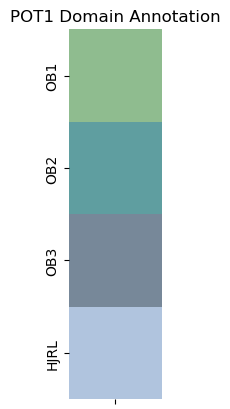

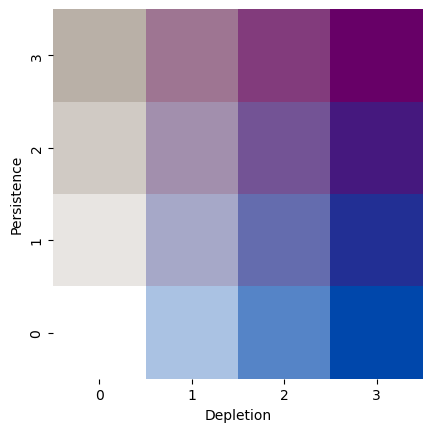

In [10]:
#create summary dot plot for the entire gene:
make_dotplot(plot_df,structure_df,combined_df,save_filepath,'POT1_Summary',True)

In [11]:
#create dot plots for each exon:
all_exons = unique(plot_df.Exon.tolist())
for exon in all_exons:
    ex_plot_df = plot_df[plot_df.Exon==exon].copy()
    ex_combined_df = combined_df[combined_df.Exon==exon].copy()
    if not os.path.isdir(os.path.join(save_filepath,str(exon))):
        os.mkdir(os.path.join(save_filepath,str(exon)))
    make_dotplot(ex_plot_df,structure_df,ex_combined_df,os.path.join(save_filepath,str(exon)),'Exon%d'%exon,False)

In [10]:
#Split the summary dot plot into a number of sub plots for easier visualization:
split_into = 3
if not os.path.isdir(os.path.join(save_filepath,'Scaled_SummarySplit%d'%split_into)):
    os.mkdir(os.path.join(save_filepath,'Scaled_SummarySplit%d'%split_into))
step = math.ceil((len(prot_seq)-1)/split_into)
for x in range(0,max(plot_df.position.tolist()),step):
    split_plot_df = plot_df[plot_df.position > x].copy()
    split_plot_df = split_plot_df[split_plot_df.position <= x+step].copy()

    split_combined_df = combined_df[combined_df.position > x].copy()
    split_combined_df = split_combined_df[split_combined_df.position <= x+step].copy()
    make_dotplot(split_plot_df,structure_df,split_combined_df,os.path.join(save_filepath,'Scaled_SummarySplit%d'%split_into),'AA%d-%d'%(x+1,x+step),False)